In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.optimize import curve_fit
from src.maths.Error import r_squared
from src.plotter.Plotter import Plotter

In [2]:
data = requests.get('http://77.246.98.155/database/phase_diagram/?format=json').json()
temperature = np.array([dat['temperature'] for dat in data if dat['temperature']])
pressure = np.array([dat['pressure'] for dat in data if dat['temperature']])
density = np.array([dat['density'] for dat in data if dat['temperature']])

MIN_TEMPERATURE = min(temperature)
MAX_TEMPERATURE = max(temperature)
MIN_PRESSURE = min(pressure)
MAX_PRESSURE = max(pressure)
MIN_DENSITY = min(density)
MAX_DENSITY = max(density)

linearized_temperature = (temperature - MIN_TEMPERATURE) / (MAX_TEMPERATURE - MIN_TEMPERATURE)
linearized_pressure = (pressure - MIN_PRESSURE) / (MAX_PRESSURE - MIN_PRESSURE)
linearized_density = (density - MIN_DENSITY) / (MAX_DENSITY - MIN_DENSITY)

In [3]:
M = 200.59e-3
R = 8.31

<h2 align='center'>Viral equation without temperature</h2>

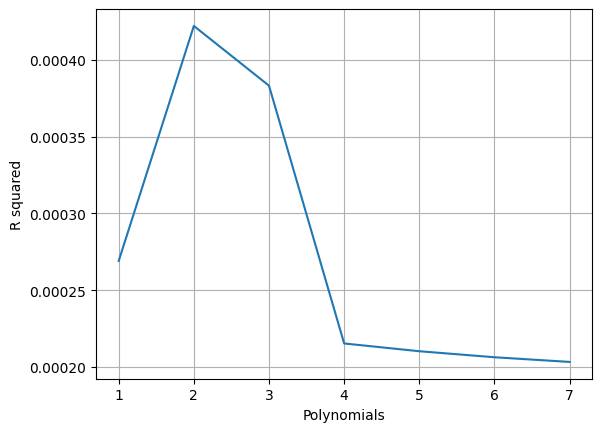

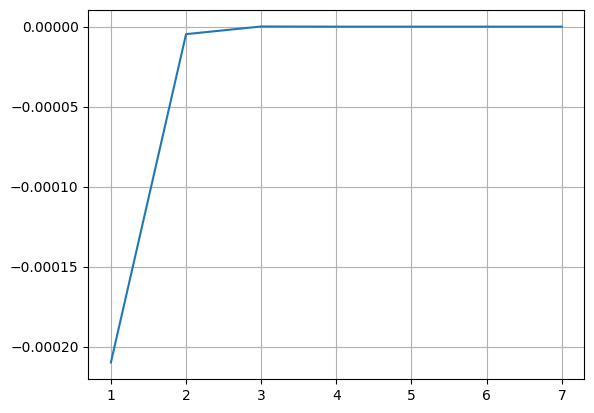

In [4]:
def equation1(x, a):
    return x + a * x ** 2

def equation2(x, a, b):
    return x + a * x ** 2 + b * x ** 3
    
def equation3(x, a, b, c):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4

def equation4(x, a, b, c, d):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4 + d * x ** 5

def equation5(x, a, b, c, d, f):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4 + d * x ** 5 + f * x ** 6

def equation6(x, a, b, c, d, f, e):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4 + d * x ** 5 + f * x ** 6 + e * x ** 7

def equation7(x, a, b, c, d, f, e, g):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4 + d * x ** 5 + f * x ** 6 + e * x ** 7 + g * x ** 8

Z = pressure * M / (R * temperature)

popt1, pcov1 = curve_fit(equation1, density, Z)
popt2, pcov2 = curve_fit(equation2, density, Z)
popt3, pcov3 = curve_fit(equation3, density, Z)
popt4, pcov4 = curve_fit(equation4, density, Z)
popt5, pcov5 = curve_fit(equation5, density, Z)
popt6, pcov6 = curve_fit(equation6, density, Z)
popt7, pcov7 = curve_fit(equation7, density, Z)

r = np.array([r_squared(equation1(density, *popt1), Z), r_squared(equation2(density, *popt2), Z),
     r_squared(equation3(density, *popt3), Z), r_squared(equation4(density, *popt4), Z),
     r_squared(equation5(density, *popt5), Z), r_squared(equation6(density, *popt6), Z),
     r_squared(equation7(density, *popt7), Z), 
])

plt.plot(range(1, 8), 1-r)
plt.xlabel('Polynomials')
plt.ylabel(r'R squared')
plt.grid(True)
plt.show()

plt.plot(range(1, 8), popt7)
plt.grid(True)
plt.show()


<h2 align='center'>Viral equation with temperature</h2>

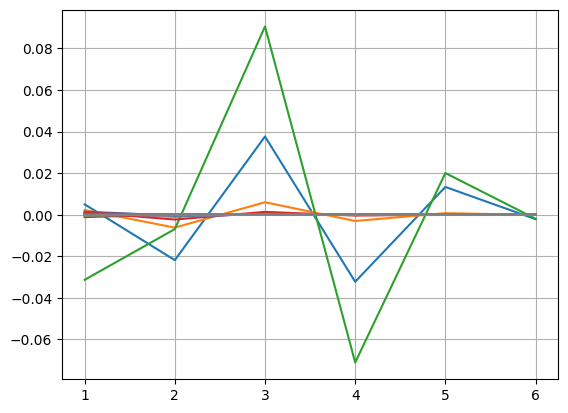

In [5]:
def equation1(x, a):
    return x + a * x ** 2

def equation2(x, a, b):
    return x + a * x ** 2 + b * x ** 3
    
def equation3(x, a, b, c):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4

def equation4(x, a, b, c, d):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4 + d * x ** 5

def equation5(x, a, b, c, d, f):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4 + d * x ** 5 + f * x ** 6

def equation6(x, a, b, c, d, f, e):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4 + d * x ** 5 + f * x ** 6 + e * x ** 7

def equation7(x, a, b, c, d, f, e, g):
    return x + a * x ** 2 + b * x ** 3 + c * x ** 4 + d * x ** 5 + f * x ** 6 + e * x ** 7 + g * x ** 8

temperature_set = sorted(list(set(temperature)))

coeff = []
temperatures = []
for temp in temperature_set:
    index = np.where(temperature == temp)
    temperature_temp = temperature[index]
    pressure_temp = pressure[index]
    density_temp = density[index]
    
    if len(temperature_temp) < 6: continue
    
    Z_temp = pressure_temp * M / (R * temperature_temp)
    popt, pcov = curve_fit(equation6, density_temp, Z_temp)
    coeff.append(popt)
    temperatures.append(temp)
    
coeff = np.array(coeff).T
plt.plot(range(1, 7), coeff)
plt.grid(True)
plt.show()

# plt.plot(temperatures, coeff)
# plt.grid(True)
# plt.show()

<h2 align='center'> Neural network for phase </h2>

In [13]:
inputs = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(20, activation='tanh')(inputs)
x = tf.keras.layers.Dense(20, activation='gelu')(x)
x = tf.keras.layers.Dense(20, activation='gelu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss="mse", metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 20)                60        
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 921 (3.60 KB)
Trainable params: 921 (3.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# index = (temperature < 0.2) & (temperature > 0)

index = np.arange(len(temperature))
np.random.shuffle(index)

x_train = np.array([linearized_temperature[index], linearized_pressure[index]]).T
y_train = np.array([linearized_density[index]]).T
train = model.fit(x_train, y_train, epochs=1000, validation_split=0.4)

Epoch 1/1000
16/16 [==============================] - 2s 18ms/step - loss: 0.2072 - accuracy: 0.0020 - val_loss: 0.1794 - val_accuracy: 0.0030
Epoch 2/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.1674 - accuracy: 0.0000e+00 - val_loss: 0.1382 - val_accuracy: 0.0030
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.1226 - accuracy: 0.0000e+00 - val_loss: 0.0913 - val_accuracy: 0.0030
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0753 - accuracy: 0.0000e+00 - val_loss: 0.0515 - val_accuracy: 0.0030
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0319 - val_accuracy: 0.0030
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.0000e+00 - val_loss: 0.0254 - val_accuracy: 0.0030
Epoch 7/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.0000e+00 - val_loss: 0.0217 - va

27/27 [==============================] - 0s 3ms/step


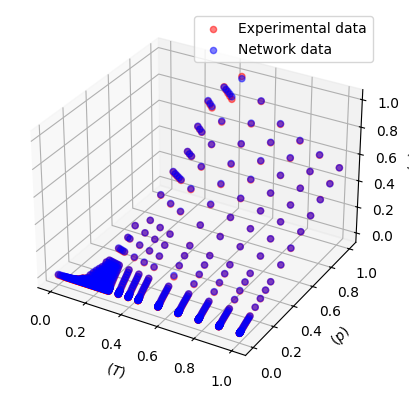

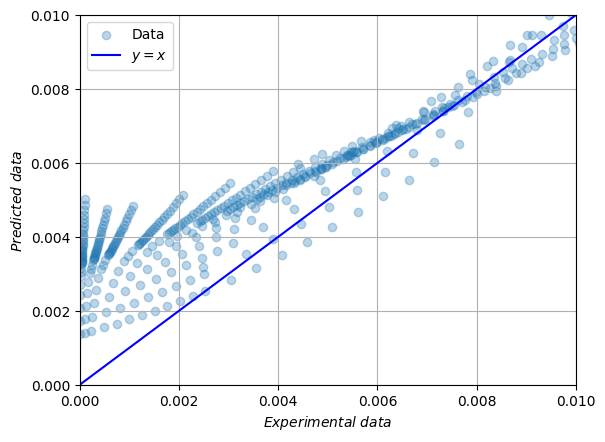

In [22]:
x_test = np.array([linearized_temperature, linearized_pressure]).T
y_test = model.predict(x_test).T

plotter = Plotter(dimension='3d')
plotter.scatter(linearized_temperature, linearized_pressure, linearized_density, color='r', alpha=0.5)
plotter.scatter(linearized_temperature, linearized_pressure, y_test, color='b', alpha=0.5)
plotter.xlabel(r'$(T)$')
plotter.ylabel(r'$(p)$')
plotter.zlabel(r'$(\rho)$')
plotter.legend(['Experimental data', 'Network data'])
plotter.save('data_network_experimental.jpg')
plotter.show()

linear_x = np.linspace(0, 1, 100)
linear_y = linear_x

plotter = Plotter(dimension='2d')
plt.scatter(linearized_density, y_test, alpha=0.3)
plt.plot(linear_x, linear_y, 'b-')
plt.xlabel(r'$Experimental$ $data$')
plt.ylabel(r'$Predicted$ $data$')
plt.legend(['Data', '$y=x$'])
plt.grid(True)
plt.xlim([0, 0.01])
plt.ylim([0, 0.01])
plt.show()

In [16]:
y_test_reshape = np.reshape(y_test, (837,))

r_squared(y_test_reshape, linearized_density)

0.9991734423886021

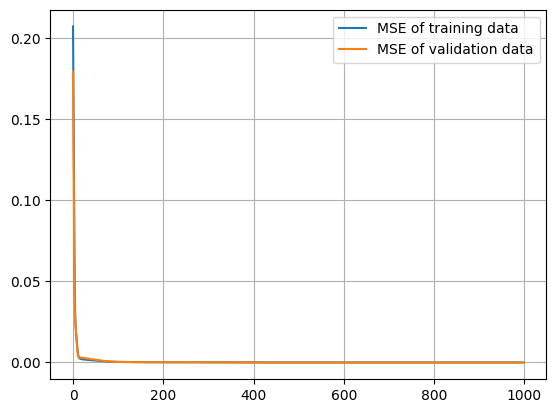

In [26]:
val_loss = train.history['val_loss']
loss = train.history['loss']
plt.plot(range(0, len(loss)), loss)
plt.plot(range(0, len(val_loss)), val_loss)
# plt.xlim([500, 1000])
# plt.ylim([0, 4e-5])
plt.legend(['MSE of training data', 'MSE of validation data'])
plt.grid(True)
plt.show()

In [19]:
np.mean(loss[200: 600])

4.245619496259678e-05